In [63]:
import matplotlib.pyplot as plt
import numpy as np
# PyCoSPath
from pycospath.cos import   ConstAdvRep          as car,   \
                            ConstAdvRepParamTan  as carpt, \
                            ReaxPathCons         as rpc,   \
                            ReaxPathConsGradProj as rpcgp, \
                            StringMethod         as sm,    \
                            StringMethodGradProj as smgp,  \
                            CosBase
from pycospath.chain import Chain2D
from pycospath.comms.twodim import Rep2D, PotMuller
from pycospath.opt import ConsGradientDescent

In [64]:
def exec_cos(cosname: str):
    """Execute the cos descent and record the descending trajectories. """

    # Control vars.
    n_reps  = 11   # Number of replicas on the chain.
    n_steps = 1000  # Number of descending steps per optimization phase. 

    # Initialize cos optimization. 
    pot = PotMuller()

    ## Linear interception between (0, 0) and (0, 2)
    xs = np.zeros((n_reps, ))
    ys = np.linspace(0.4, 1.8, num=n_reps)

    ## Make a list of Replicas. 
    rep_list = []

    for i_rep in range(n_reps):
        coor = np.asarray([xs[i_rep], ys[i_rep]])
        rep = Rep2D(coor, pot)
        rep_list.append(rep)

    chain = Chain2D(rep_list)

    cos = car  (chain, verbose=False, cons_log_writer=open('./ms0_car/fig_muller/car_cons.log'  , 'w')) if cosname == 'car'   else \
          carpt(chain, verbose=False, cons_log_writer=open('./ms0_car/fig_muller/carpt_cons.log', 'w')) if cosname == 'carpt' else \
          rpc  (chain, verbose=False, cons_log_writer=open('./ms0_car/fig_muller/rpc_cons.log'  , 'w')) if cosname == 'rpc'   else \
          rpcgp(chain, verbose=False, cons_log_writer=open('./ms0_car/fig_muller/rpcgp_cons.log', 'w')) if cosname == 'rpcgp' else \
          sm   (chain)                                                                                  if cosname == 'sm'    else \
          smgp (chain)


    opt = ConsGradientDescent(cos)

    # Initial chain_vec
    init_cvec = chain.get_chain_vec()

    # Trajectory of chain_vec
    traj_cvec = []

    # Evolve the cos and record the chain_vec per step. 
    ## 100 steps with fixed leanring rate.
    for _ in range(n_steps):
        opt.step()
        traj_cvec.append(chain.get_chain_vec())

    ## 100 steps with down-scaling learning rate.
    opt._gd_eta_scal = .98
    for _ in range(n_steps):
        opt.step()
        if _ % 20 == 0:
            traj_cvec.append(chain.get_chain_vec())
    
    # Final chain_vec
    finl_cvec = chain.get_chain_vec()

    return init_cvec, traj_cvec, finl_cvec

out_car   = exec_cos('carpt')

[-1.2   -1.183 -1.166 -1.149 -1.132 -1.115 -1.098 -1.081 -1.064 -1.047
 -1.03  -1.013 -0.996 -0.979 -0.962 -0.945 -0.928 -0.911 -0.894 -0.877
 -0.86  -0.843 -0.826 -0.809 -0.792 -0.775 -0.758 -0.741 -0.724 -0.707
 -0.69  -0.673 -0.656 -0.639 -0.622 -0.605 -0.588 -0.571 -0.554 -0.537
 -0.52  -0.503 -0.486 -0.469 -0.452 -0.435 -0.418 -0.401 -0.384 -0.367
 -0.35  -0.333 -0.316 -0.299 -0.282 -0.265 -0.248 -0.231 -0.214 -0.197
 -0.18  -0.163 -0.146 -0.129 -0.112 -0.095 -0.078 -0.061 -0.044 -0.027
 -0.01   0.007  0.024  0.041  0.058  0.075  0.092  0.109  0.126  0.143
  0.16   0.177  0.194  0.211  0.228  0.245  0.262  0.279  0.296  0.313
  0.33   0.347  0.364  0.381  0.398  0.415  0.432  0.449  0.466  0.483
  0.5  ] [0.2   0.217 0.234 0.251 0.268 0.285 0.302 0.319 0.336 0.353 0.37  0.387
 0.404 0.421 0.438 0.455 0.472 0.489 0.506 0.523 0.54  0.557 0.574 0.591
 0.608 0.625 0.642 0.659 0.676 0.693 0.71  0.727 0.744 0.761 0.778 0.795
 0.812 0.829 0.846 0.863 0.88  0.897 0.914 0.931 0.948 0.965 0

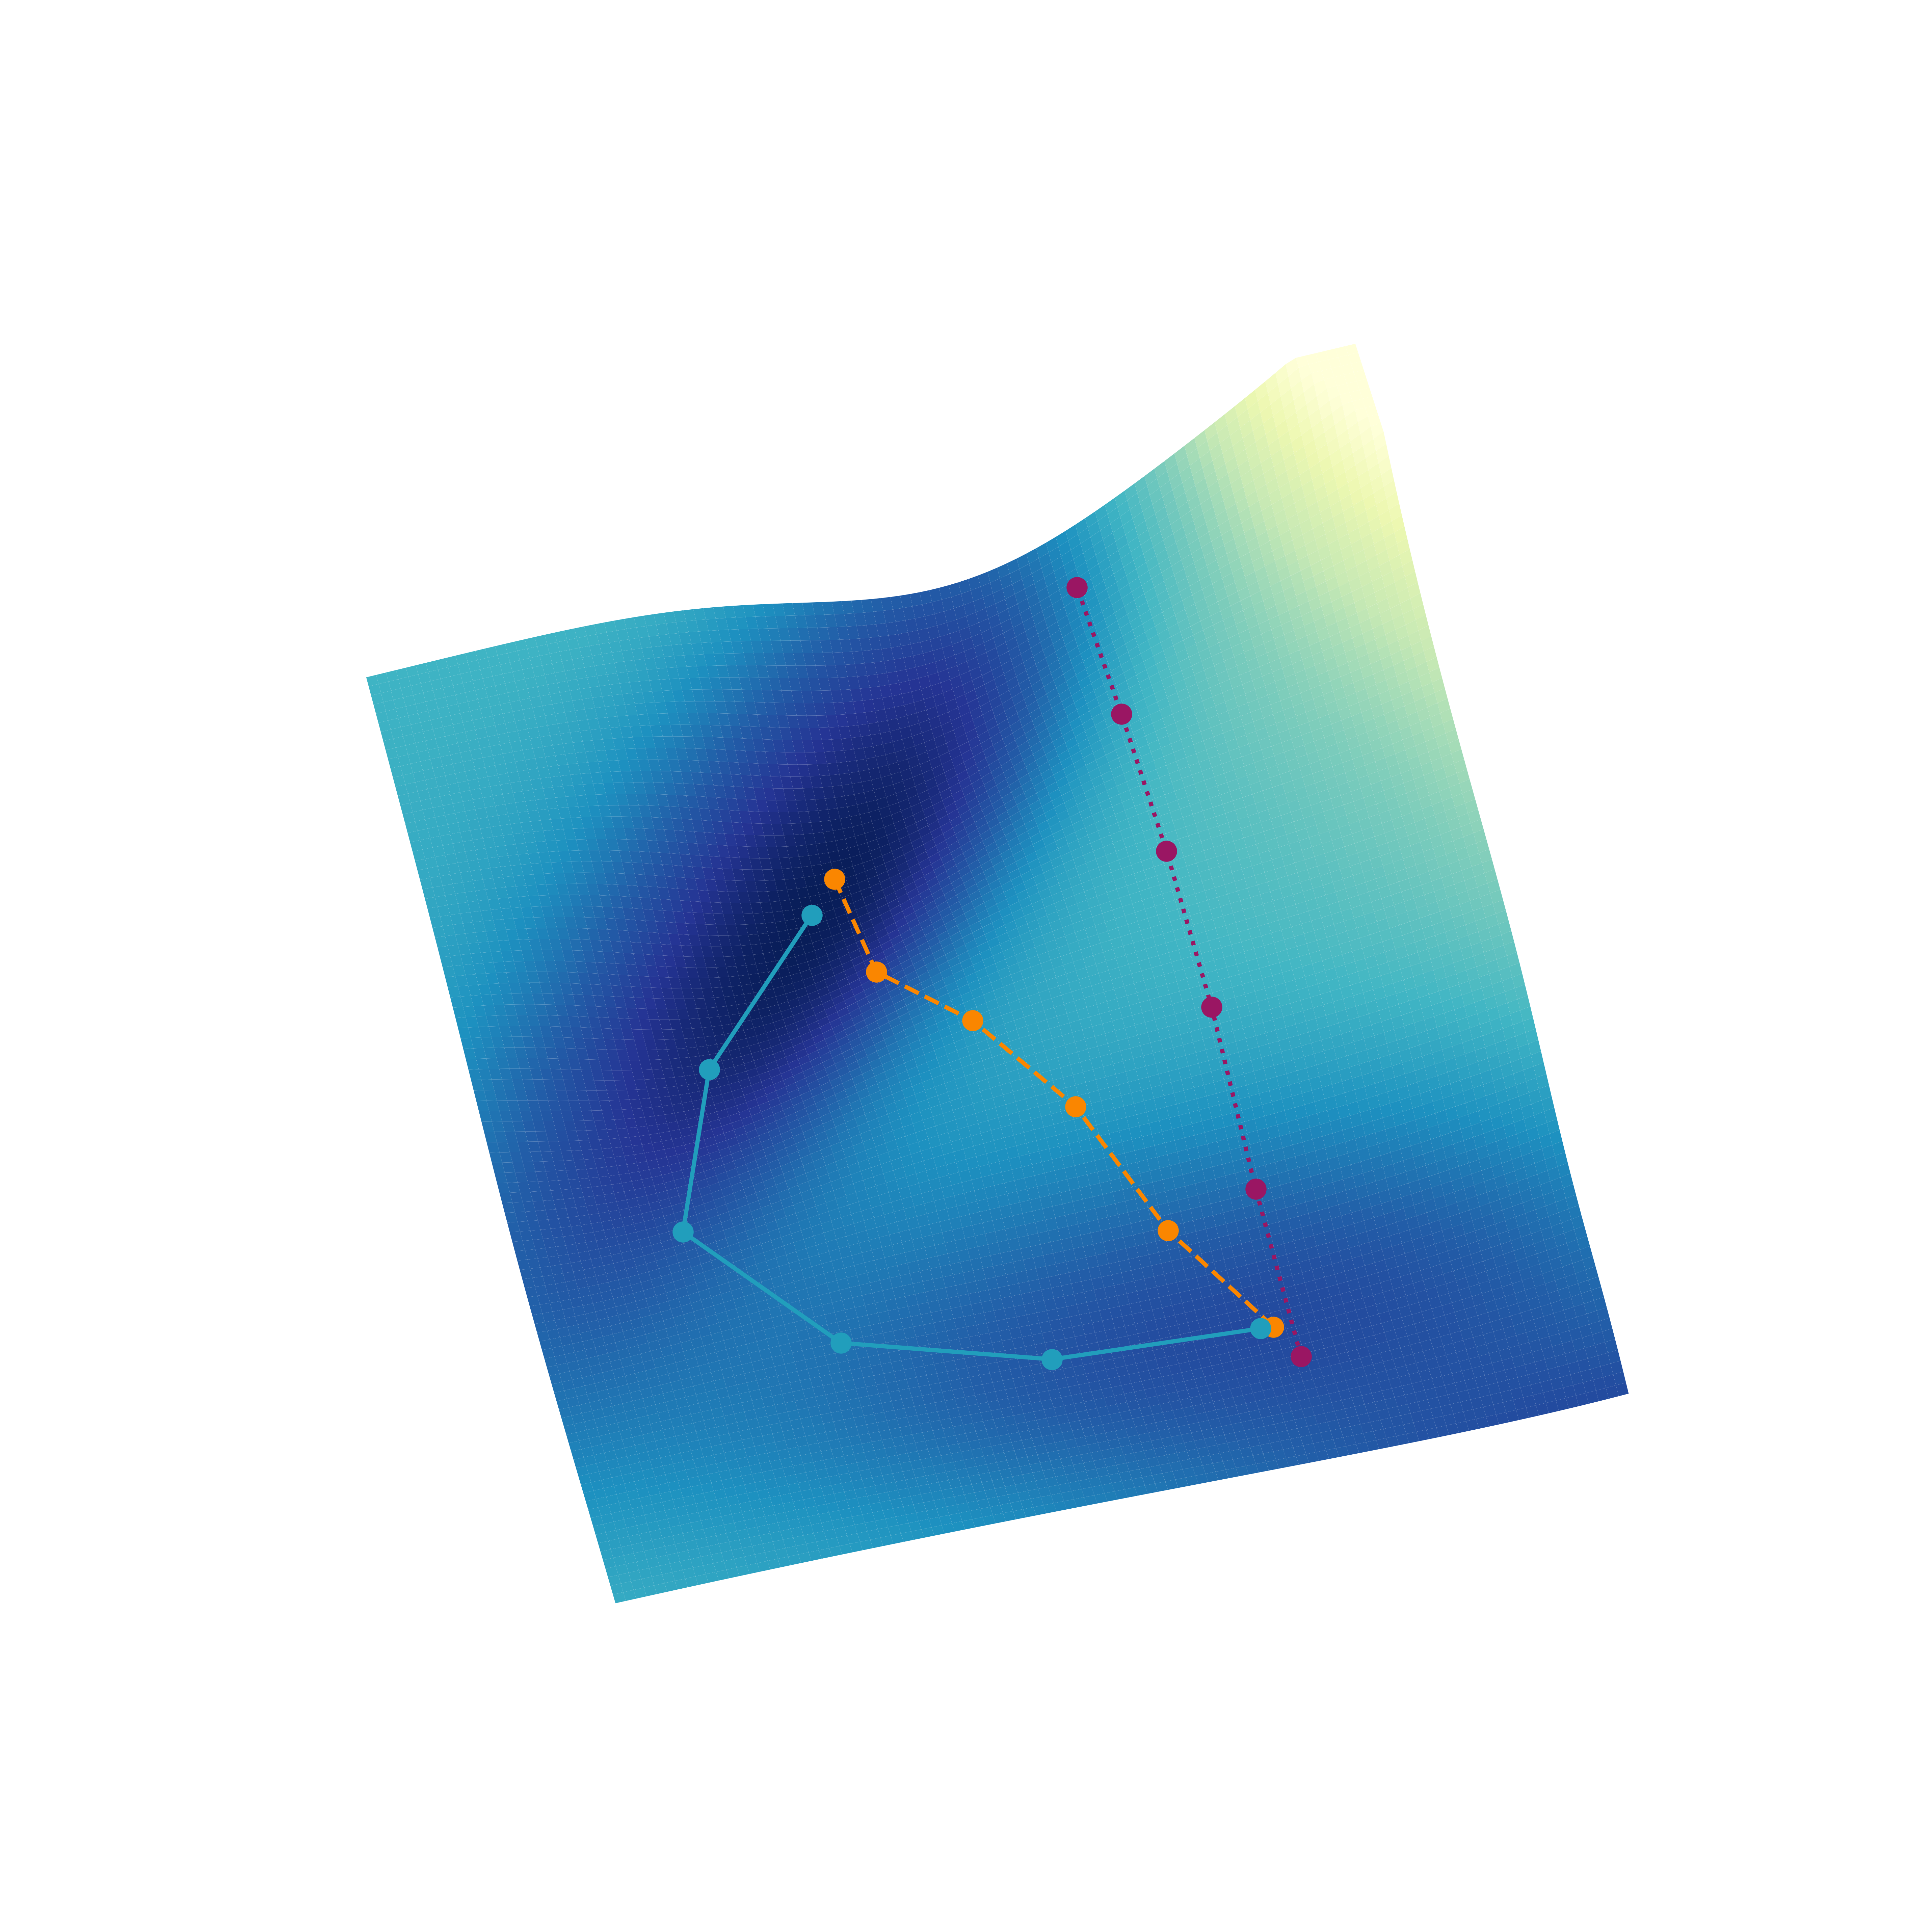

In [65]:
car_path = np.load('./ms0_car/fig_exploit/dense_rep/carpt_cvec.npy')
car_ini, car_opt = car_path[0], car_path[1]
car_ini_opt = np.asarray([car_ini, car_opt])
car_ini_v = np.asarray([PotMuller().get_ener(cor) for cor in car_ini])
car_opt_v = np.asarray([PotMuller().get_ener(cor) for cor in car_opt])

car_ini_dot, car_opt_dot = out_car[0], out_car[2]
car_ini_dot_v = np.asarray([PotMuller().get_ener(cor) for cor in car_ini_dot])
car_opt_dot_v = np.asarray([PotMuller().get_ener(cor) for cor in car_opt_dot])

car_traj = out_car[1]

car_traj_v = []
for t in car_traj:
    car_traj_v.append(np.asarray([PotMuller().get_ener(cor) for cor in t]))

x,y,v = PotMuller().get_pes(xmin=-1.2, 
                            xmax=0.5, 
                            ymin=0.2, 
                            ymax=1.9, )

print(x, y)
x, y = np.meshgrid(x, y)


fig = plt.figure(dpi=900, figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(x, y, v, cmap=plt.cm.YlGnBu_r, rstride=1, cstride=1)
ax.plot(car_ini_dot[:, 0][::2],  car_ini_dot[:, 1][::2],  car_ini_dot_v[::2],  c='#9A1663', zorder=199, lw=1., marker='.', markersize=8, ls=':')
ax.plot(car_traj[35][:, 0][::2], car_traj[35][:, 1][::2], car_traj_v[35][::2], c='#FA8600', zorder=100, lw=1., marker='.', markersize=8, ls='--')
ax.plot(car_opt_dot[:, 0][::2],  car_opt_dot[:, 1][::2],  car_opt_dot_v[::2],  c='#219EBC', zorder=199, lw=1., marker='.', markersize=8)

ax.view_init(elev=65, azim=255)


ax.set_axis_off()
ax.set_zlim3d(-200, 500)

fig.savefig('toc.jpg')